In [38]:
import argparse
import time
import torch
import numpy as np
import os
import torch.optim as optim

# custom modules

from loss import MonodepthLoss
from utils import get_model, to_device, prepare_dataloader
import os
from PIL import Image
# plot params
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms as transforms
import cv2

In [39]:
model = get_model("resnet18_md_v2", input_channels=3, pretrained=False)
model=model.to("cuda")        

In [40]:
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("model_output/res18_v2/resnet18-5c106cde_cpt.pth"))

<All keys matched successfully>

In [41]:
max_depth = 50;
min_depth = 1;
min_disp  = 1;
def post_process_disparity(disp):
    (_, h, w) = disp.shape
    l_disp = disp[0, :, :]
    r_disp = np.fliplr(disp[1, :, :])
    m_disp = 0.5 * (l_disp + r_disp)
    (l, _) = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    l_mask = 1.0 - np.clip(20 * (l - 0.05), 0, 1)
    r_mask = np.fliplr(l_mask)
    return r_mask * l_disp + l_mask * r_disp + (1.0 - l_mask - r_mask) * m_disp

def disp2depth( disp, max_disp ):
    disp[ disp < min_disp ] = min_disp;
    depth = (3233.93339530 * 0.245) / disp;
    depth[depth < min_depth] = min_depth;
    depth[depth > max_depth] = max_depth;
    return depth
totensor = transforms.ToTensor()
model.eval()
with torch.no_grad():
    RGB_image = np.array(Image.open("MTN_data/testing/Campus/LEFT/LEFT_000004533.jpg"))
    left_image = Image.open("MTN_data/testing/Campus/THERMAL/THER_000004533.jpg").convert("RGB")
    left_tensor=totensor(left_image)
    left_tensor = torch.stack((left_tensor, torch.flip(left_tensor, [2])))
    disps=model(left_tensor.cuda())
    disp     = disps[0][:, 0, :, :].unsqueeze(1)
    disp     = disp[0].squeeze().cpu().numpy()
    disp_pp  = post_process_disparity(disps[0][:, 0, :, :].cpu().numpy())
    disp_pp  = disp_pp *1280
    depth_pp = disp2depth( disp_pp, 0.1*disp_pp.shape[1] );

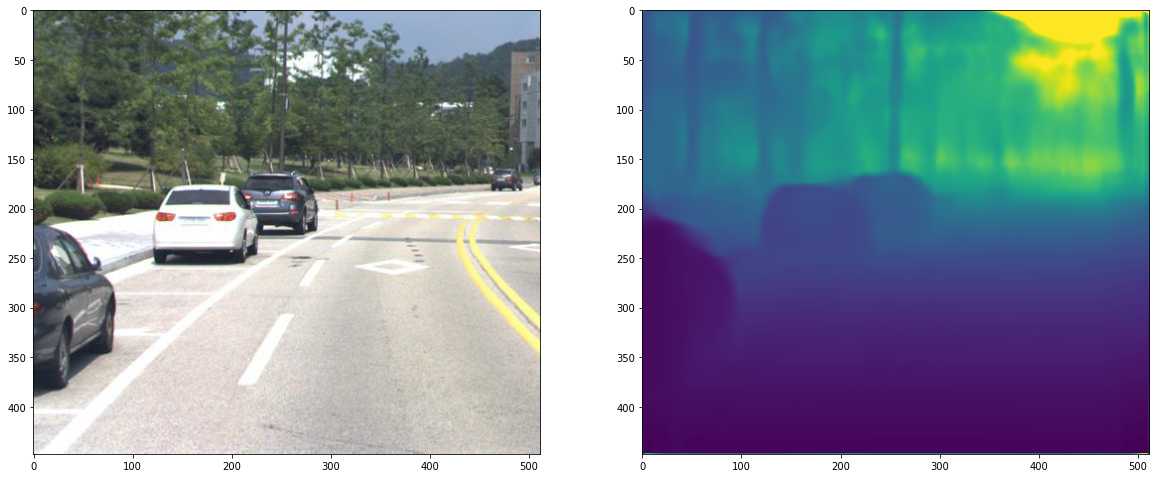

In [42]:
import cv2
fig, ax = plt.subplots(1,2, figsize=(20,10))
flipVertical = cv2.flip(RGB_image, 1)
ax[0].imshow(flipVertical)
flipVertical = cv2.flip(depth_pp, 1)
ax[1].imshow(flipVertical)


In [44]:
d = np.flipud(depth_pp)
img = np.flipud(RGB_image)

CPU times: user 14.2 s, sys: 418 ms, total: 14.6 s
Wall time: 14.4 s


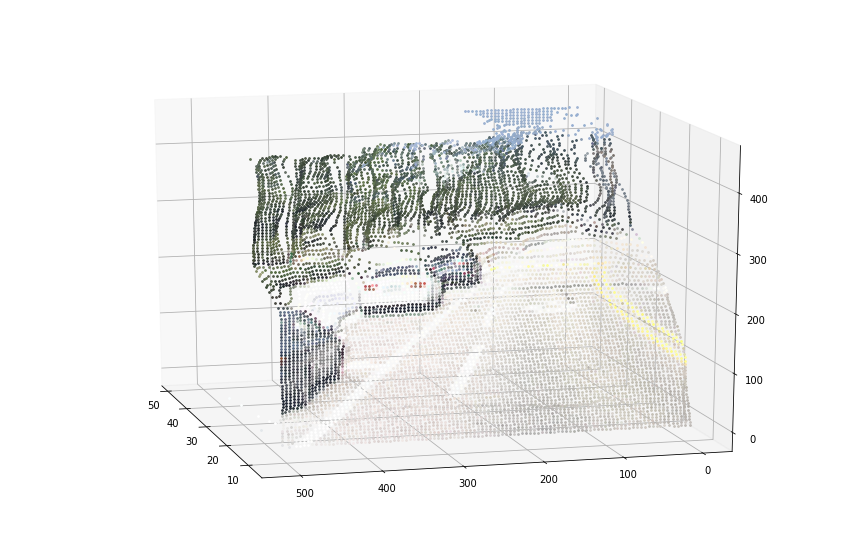

In [45]:
%%time
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

STEP = 5
for x in range(0,img.shape[0], STEP):
    for y in range(0, img.shape[1], STEP):
        
        ax.scatter(
            d[x,y], y, x,
            c=[tuple(img[x, y, :3]/255)], s=3)      
    ax.view_init(15, 165)